# Training the CNN

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pipeline.config as conf
import pipeline.scale as scale
import octafilt3r.plot as o3p

In [1]:
param_dict = conf.open_params()

labels = np.loadtxt(param_dict["label_txt_fp"], dtype='str')
df_2d = np.loadtxt(param_dict["extr_txt_fp"])
df = df_2d.reshape(df_2d.shape[0], df_2d.shape[1] // param_dict['n_bands'], param_dict['n_bands'])

(22770, 48, 21)


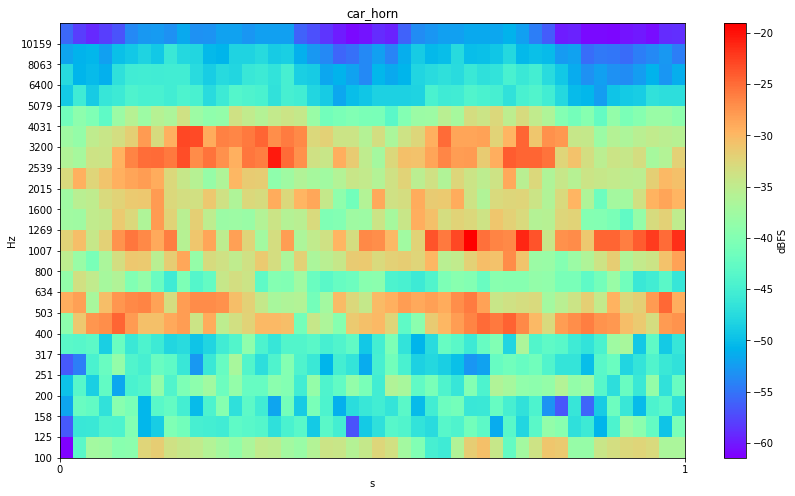

In [2]:
# sanity check:
print(df.shape)
o3p.oct_spectrogram(df[600], 
                    param_dict['fs'], 
                    param_dict['frame_size'], 
                    param_dict['fmax'], 
                    param_dict['fmin'], 
                    param_dict['oct_bw_ratio'], 
                    labels[600])

In [3]:
y, encoder = scale.label_encode(labels)
X, scaler = scale.data_scaler(df)
print(f'Encoded labels:\n{y}')
print(f'Shape of data frame: {X.shape}')
# Dividing data into training and Testing set
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2)


Encoded labels:
[0 0 0 ... 6 6 6]
Shape of data frame: (22770, 48, 21, 1)


In [4]:
# https://gist.github.com/jaron/5b17c9f37f351780744aefc74f93d3ae
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
from sklearn import metrics 

kernel_size = (5, 5)
n_classes = max(y_test) + 1 # highest index + 1 is the amount of classes
print(f'Input shape: {X[0].shape}')
print(f'Output shape: {n_classes}')

layer_1 = [
    Conv2D(24, kernel_size, padding='same', input_shape=X[0].shape),
    MaxPooling2D(pool_size=(2,2)),
    Activation('relu')
]

layer_2 = [
    Conv2D(48, kernel_size, padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Activation('relu')
]

layer_3 = [
    Conv2D(48, kernel_size, padding='valid'),
    Activation('relu'),
]

layer_4 = [
    Flatten(),
    Dropout(0.5),
    Dense(64, kernel_regularizer=l2(0.001)),
    Activation('relu')
]

layer_5 = [
    Dropout(0.5),
    Dense(n_classes, kernel_regularizer=l2(0.001)),
    Activation('softmax')
]

layers = layer_1 + layer_2 + layer_3 + layer_4 + layer_5
model = Sequential(layers)

sgd = SGD(learning_rate=0.001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.fit(X_train, y_train, batch_size=4, epochs=100)

Input shape: (48, 21, 1)
Output shape: 7
Epoch 1/150
4554/4554 [==============================] - 43s 9ms/step - loss: 1.8542 - accuracy: 0.2692
Epoch 2/150
4554/4554 [==============================] - 45s 10ms/step - loss: 1.5869 - accuracy: 0.3758
Epoch 3/150
4554/4554 [==============================] - 46s 10ms/step - loss: 1.4762 - accuracy: 0.4392
Epoch 4/150
4554/4554 [==============================] - 38s 8ms/step - loss: 1.3972 - accuracy: 0.4844
Epoch 5/150
4554/4554 [==============================] - 41s 9ms/step - loss: 1.3344 - accuracy: 0.5190
Epoch 6/150
4554/4554 [==============================] - 41s 9ms/step - loss: 1.2856 - accuracy: 0.5431
Epoch 7/150
4554/4554 [==============================] - 41s 9ms/step - loss: 1.2424 - accuracy: 0.5679
Epoch 8/150
4554/4554 [==============================] - 40s 9ms/step - loss: 1.2037 - accuracy: 0.5910
Epoch 9/150
4554/4554 [==============================] - 41s 9ms/step - loss: 1.1623 - accuracy: 0.6136
Epoch 10/150
4554/455

In [5]:
# determine the ROC AUC score 
y_prob = model.predict(X_test)
y_true = np.argmax(y_prob, 1)
roc = metrics.roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC: {round(roc,3)}")

score, accuracy = model.evaluate(X_test, y_test, batch_size=4)
print("\nAccuracy = {:.2f}".format(accuracy))

model.save(param_dict["CNN_name"])

ROC: 0.967
1139/1139 [==============================] - 6s 5ms/step - loss: 1.1528 - accuracy: 0.8254

Accuracy = 0.83
INFO:tensorflow:Assets written to: NACED_V-0-1\assets
